In [1]:
from pathlib import Path

import torch
import numpy as np
import pandas as pd

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## Set important local paths

Set your root directory:

In [3]:
# ROOT_DIR = Path("~").expanduser().resolve()     # LOCAL dir
ROOT_DIR = Path("/fast/groups/sf")            # CLUSTER dir
ROOT_DIR

PosixPath('/fast/groups/sf')

Directory where LLMs are saved:

In [4]:
MODELS_DIR = ROOT_DIR / "huggingface-models"

Directory where data is saved (or will be saved to):

In [5]:
DATA_DIR = ROOT_DIR / "data"

Other configs:

In [6]:
MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
# MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
# MODEL_NAME = "google/gemma-2b"    # NOTE: this is among the smallest models

TASK_NAME = "ACSIncome"

RESULTS_ROOT_DIR = ROOT_DIR / "folktexts-results"

In [7]:
from folktexts.llm_utils import load_model_tokenizer, get_model_folder_path
model_folder_path = get_model_folder_path(model_name=MODEL_NAME, root_dir=MODELS_DIR)
model, tokenizer = load_model_tokenizer(model_folder_path)

INFO:root:Loading model '/lustre/fast/fast/groups/sf/huggingface-models/meta-llama--Meta-Llama-3-8B'
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Moving model to device: cuda


In [8]:
results_dir = RESULTS_ROOT_DIR / Path(model_folder_path).name
results_dir.mkdir(exist_ok=True, parents=True)
results_dir

PosixPath('/fast/groups/sf/folktexts-results/meta-llama--Meta-Llama-3-8B')

### Construct LLM Classifier

Load prediction task (which maps tabular data to text):

In [9]:
from folktexts.acs import ACSTaskMetadata
task = ACSTaskMetadata.get_task(TASK_NAME)

In [10]:
from folktexts.classifier import LLMClassifier
llm_clf = LLMClassifier(
    model=model,
    tokenizer=tokenizer,
    task=task,
    batch_size=32,
)

### Load Dataset

In [11]:
%%time
from folktexts.acs import ACSDataset
dataset = ACSDataset(task=task, cache_dir=DATA_DIR)

Loading ACS data...
CPU times: user 43.1 s, sys: 32.5 s, total: 1min 15s
Wall time: 1min 16s


Optionally, subsample to quickly get approximate results:

In [12]:
dataset = dataset.subsample(0.1)
print(f"{dataset.subsampling=}")

INFO:root:Subsampled dataset to 10.0% of the original size. Train size: 149805, Test size: 16645, Val size: 0;


dataset.subsampling=0.1


### Load and run ACS Benchmark

**_Note:_** Helper constructors exist at `CalibrationBenchmark.make_acs_benchmark` and `CalibrationBenchmark.make_benchmark` that avoid the above boilerplate code.

In [13]:
from folktexts.benchmark import CalibrationBenchmark, BenchmarkConfig

bench = CalibrationBenchmark(
    llm_clf=llm_clf,
    dataset=dataset,
    config=BenchmarkConfig.default_config(),
)

INFO:root:
** Benchmark initialization **
Model: meta-llama--Meta-Llama-3-8B;
Task: ACSIncome;
Hash: 964964125;



Optionally, you can fit the model's threshold on a few data samples.

This is generally quite fast as it is _not fine-tuning_; it only changes one parameter: the `llm_clf.threshold`.

In [14]:
%%time
X_sample, y_sample = dataset.sample_n_train_examples(n=100)
llm_clf.fit(X_sample, y_sample)

Computing risk estimates:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Set threshold to 0.5456898924419886.


CPU times: user 1.85 s, sys: 428 ms, total: 2.28 s
Wall time: 3.3 s


LLMClassifier(encode_row=functools.partial(<function encode_row_prompt at 0x14df2d6a8cc0>, task=ACSTaskMetadata(name='ACSIncome', description="predict whether an individual's income is above $50,000", features=['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P'], target='PINCP_binary_50000', cols_to_text={'AGEP': <folktexts.col_to_text.ColumnToTex...
	128253: AddedToken("<|reserved_special_token_248|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128254: AddedToken("<|reserved_special_token_249|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128255: AddedToken("<|reserved_special_token_250|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
})

Run benchmark...

In [15]:
%%time
bench.run(results_root_dir=results_dir)

INFO:root:Test data features shape: (16645, 10)


Computing risk estimates:   0%|          | 0/521 [00:00<?, ?it/s]

INFO:root:
** Test results **
Model: meta-llama--Meta-Llama-3-8B;
	 ECE:       21.5%;
	 ROC AUC :  84.8%;
	 Accuracy:  77.2%;
	 Bal. acc.: 76.7%;

INFO:root:Skipping group 'American Indian' as it's too small.
INFO:root:Skipping group 'Alaska Native' as it's too small.
INFO:root:Skipping group 'American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races' as it's too small.
INFO:root:Skipping group 'Native Hawaiian and Other Pacific Islander' as it's too small.
INFO:root:Skipping group 'Two or more races' as it's too small.
INFO:root:Saving JSON file to '/lustre/fast/fast/groups/sf/folktexts-results/meta-llama--Meta-Llama-3-8B/meta-llama--Meta-Llama-3-8B_bench-917638940/results.bench-917638940.json'
INFO:root:Saved experiment results to '/lustre/fast/fast/groups/sf/folktexts-results/meta-llama--Meta-Llama-3-8B/meta-llama--Meta-Llama-3-8B_bench-917638940/results.bench-917638940.json'


CPU times: user 4min 3s, sys: 48.6 s, total: 4min 52s
Wall time: 6min 6s


0.2151204990774381

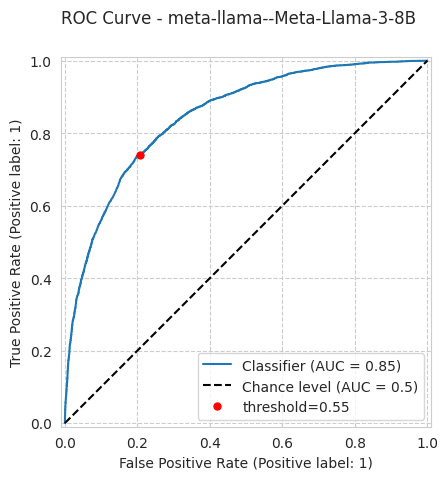

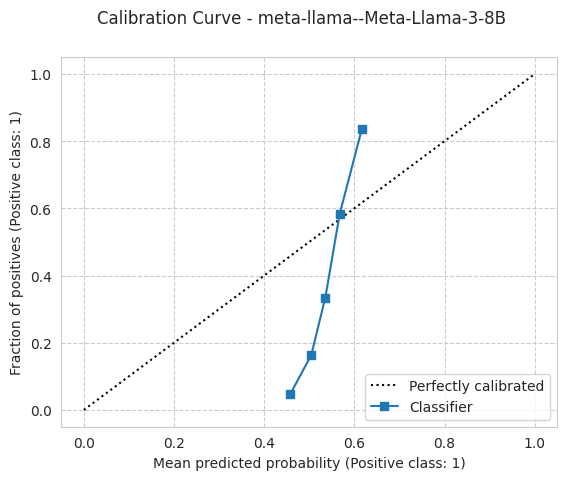

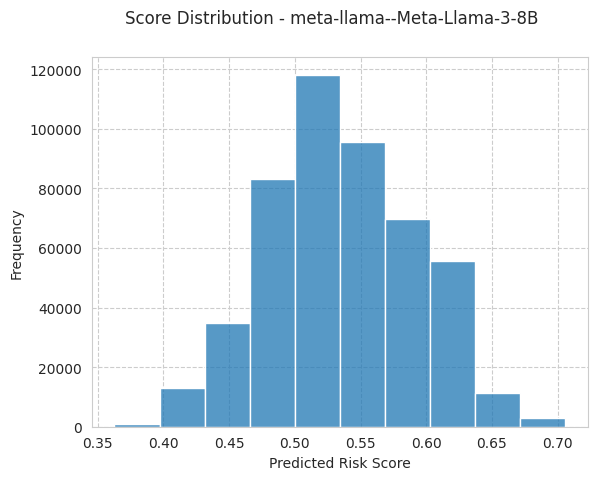

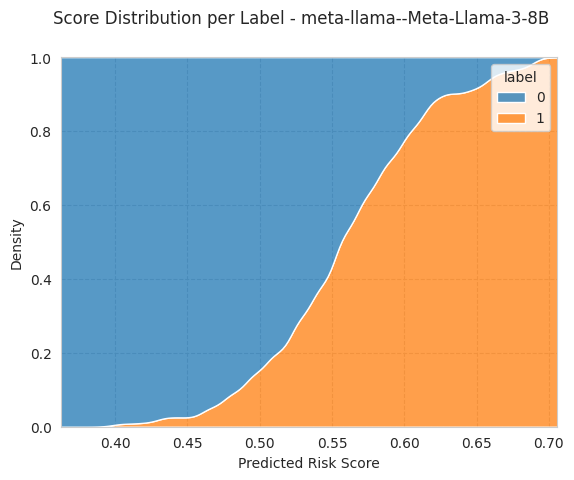

INFO:root:Skipping group 'American Indian' as it's too small.
INFO:root:Skipping group 'Alaska Native' as it's too small.
INFO:root:Skipping group 'American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races' as it's too small.
INFO:root:Skipping group 'Native Hawaiian and Other Pacific Islander' as it's too small.
INFO:root:Skipping group 'Two or more races' as it's too small.


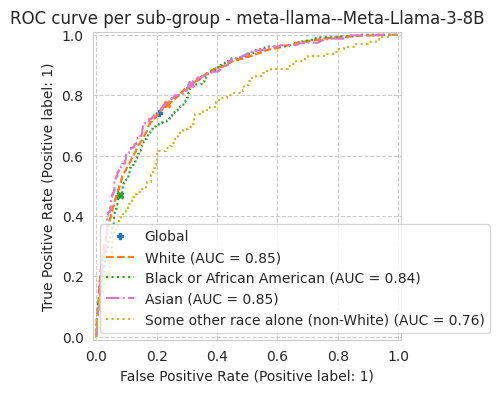

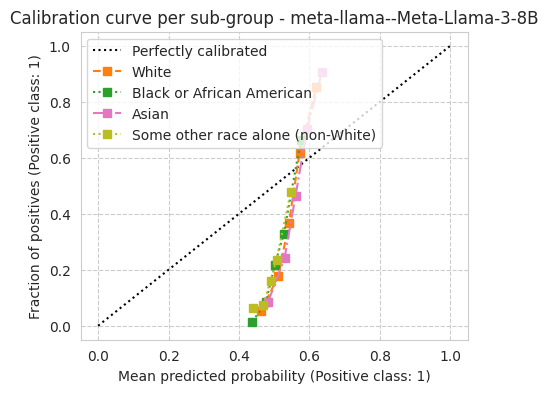

In [16]:
bench.plot_results();

In [17]:
from pprint import pprint
pprint(bench.results, depth=1)

{'accuracy': 0.7722439170922198,
 'accuracy_diff': 0.3076923076923077,
 'accuracy_ratio': 0.6923076923076923,
 'balanced_accuracy': 0.7667842719226445,
 'balanced_accuracy_diff': 0.26710110957152255,
 'balanced_accuracy_ratio': 0.6518045584359584,
 'brier_score_loss': 0.2302842598118175,
 'config': {...},
 'ece': 0.2151204990774381,
 'ece_quantile': 0.24375698760688566,
 'equalized_odds_diff': 0.8366013071895425,
 'equalized_odds_ratio': 0.0,
 'fnr': 0.2587498089561363,
 'fnr_diff': 0.8366013071895425,
 'fnr_ratio': 0.16339869281045752,
 'fpr': 0.20768164719857454,
 'fpr_diff': 0.312625250501002,
 'fpr_ratio': 0.0,
 'log_loss': 0.6530657616051052,
 'model_name': 'meta-llama--Meta-Llama-3-8B',
 'n_negatives': 10102,
 'n_positives': 6543,
 'n_samples': 16645,
 'plots': {...},
 'ppr': 0.41742264944427754,
 'ppr_diff': 0.5636743215031316,
 'ppr_ratio': 0.0,
 'precision': 0.6980426021876799,
 'precision_diff': 1.0,
 'precision_ratio': 0.0,
 'predictions_path': '/lustre/fast/fast/groups/sf/f

---